In [4]:
# Conditional GAN to create mnist image samples from latent space ( noise ) and y ( class label , in this case digit label)


In [5]:
from __future__ import division, print_function, absolute_import

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

In [6]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [7]:
y_dim = mnist.train.labels.shape[1]

In [8]:
# Training Params
num_steps = 70000
batch_size = 128
learning_rate = 0.0002

# Network Params
image_dim = 784 # 28*28 pixels
gen_hidden_dim = 256
disc_hidden_dim = 256
noise_dim = 100 # Noise data points

# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

In [9]:
# Store layers weight & bias
weights = {
    'gen_hidden1': tf.Variable(glorot_init([noise_dim + y_dim, gen_hidden_dim])),
    'gen_out': tf.Variable(glorot_init([gen_hidden_dim, image_dim])),
    'disc_hidden1': tf.Variable(glorot_init([image_dim + y_dim, disc_hidden_dim])),
    'disc_out': tf.Variable(glorot_init([disc_hidden_dim, 1])),
}
biases = {
    'gen_hidden1': tf.Variable(tf.zeros([gen_hidden_dim])),
    'gen_out': tf.Variable(tf.zeros([image_dim])),
    'disc_hidden1': tf.Variable(tf.zeros([disc_hidden_dim])),
    'disc_out': tf.Variable(tf.zeros([1])),
}


In [10]:
# Generator
def generator(x,y):
    
    x=tf.concat(axis=1, values=[x, y])
    hidden_layer = tf.matmul(x, weights['gen_hidden1'])
    hidden_layer = tf.add(hidden_layer, biases['gen_hidden1'])
    hidden_layer = tf.nn.relu(hidden_layer)
    out_layer = tf.matmul(hidden_layer, weights['gen_out'])
    out_layer = tf.add(out_layer, biases['gen_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer


# Discriminator
def discriminator(x,y):
    
    x=tf.concat(axis=1, values=[x, y])
    hidden_layer = tf.matmul(x, weights['disc_hidden1'])
    hidden_layer = tf.add(hidden_layer, biases['disc_hidden1'])
    hidden_layer = tf.nn.relu(hidden_layer)
    out_layer = tf.matmul(hidden_layer, weights['disc_out'])
    out_layer = tf.add(out_layer, biases['disc_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer

# Build Networks
# Network Inputs
gen_input = tf.placeholder(tf.float32, shape=[None, noise_dim], name='input_noise')
disc_input = tf.placeholder(tf.float32, shape=[None, image_dim], name='disc_input')
y_generator = tf.placeholder(tf.float32, shape=[None, y_dim])  # this is conditional class label input placeholder for generator
y_discriminator = tf.placeholder(tf.float32, shape=[None, y_dim])  # this is conditional class label input placeholder for discriminator

# Build Generator Network
gen_sample = generator(gen_input,y_generator)

# Build 2 Discriminator Networks (one from noise input, one from generated samples)
disc_real = discriminator(disc_input,y_discriminator)
disc_fake = discriminator(gen_sample, y_discriminator)

# Build Loss
gen_loss = -tf.reduce_mean(tf.log(disc_fake))
disc_loss = -tf.reduce_mean(tf.log(disc_real) + tf.log(1. - disc_fake))

# Build Optimizers
optimizer_gen = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=learning_rate)

# Training Variables for each optimizer
# By default in TensorFlow, all variables are updated by each optimizer, so we
# need to precise for each one of them the specific variables to update.
# Generator Network Variables
gen_vars = [weights['gen_hidden1'], weights['gen_out'],
            biases['gen_hidden1'], biases['gen_out']]
# Discriminator Network Variables
disc_vars = [weights['disc_hidden1'], weights['disc_out'],
            biases['disc_hidden1'], biases['disc_out']]

# Create training operations
train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [11]:
# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)

# Training
for i in range(1, num_steps+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, y_mnist = mnist.train.next_batch(batch_size)
    
    y_sample = np.zeros(shape=[batch_size, y_dim])
    y_sample[:, 7] = 1
    
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])

    # Train
    feed_dict = {disc_input: batch_x, gen_input: z , y_generator:y_sample , y_discriminator:y_mnist}
    _, _, gl, dl = sess.run([train_gen, train_disc, gen_loss, disc_loss],
                            feed_dict=feed_dict)
    if i % 2000 == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))

Step 1: Generator Loss: 0.640419, Discriminator Loss: 1.380829
Step 2000: Generator Loss: 5.503186, Discriminator Loss: 0.016003
Step 4000: Generator Loss: 4.397339, Discriminator Loss: 0.046400
Step 6000: Generator Loss: 4.460683, Discriminator Loss: 0.104719
Step 8000: Generator Loss: 4.392978, Discriminator Loss: 0.136222
Step 10000: Generator Loss: 4.280320, Discriminator Loss: 0.179940
Step 12000: Generator Loss: 4.460572, Discriminator Loss: 0.121632
Step 14000: Generator Loss: 5.093113, Discriminator Loss: 0.197632
Step 16000: Generator Loss: 5.534423, Discriminator Loss: 0.171643
Step 18000: Generator Loss: 7.353442, Discriminator Loss: 0.021188
Step 20000: Generator Loss: 6.028141, Discriminator Loss: 0.064577
Step 22000: Generator Loss: 5.552356, Discriminator Loss: 0.161504
Step 24000: Generator Loss: 6.272092, Discriminator Loss: 0.118927
Step 26000: Generator Loss: 7.034872, Discriminator Loss: 0.158477
Step 28000: Generator Loss: 6.775108, Discriminator Loss: 0.103515
Ste

KeyboardInterrupt: 

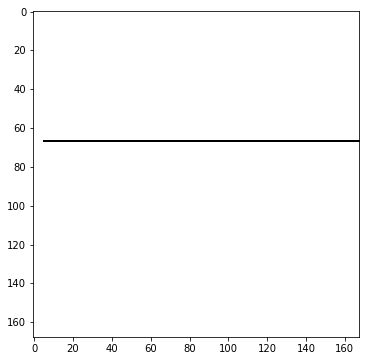

In [16]:
# Testing
# Generate images from noise, using the generator network.
n = 6
canvas = np.empty((28 * n, 28 * n))

# Noise input.
z = np.random.uniform(-1., 1., size=[n, noise_dim])
    
    
# generate class label y for each sample
y_sample = np.zeros(shape=[6, y_dim])
y_sample[:, 5] = 1
    
    
# Generate image from noise.
g = sess.run(gen_sample, feed_dict={gen_input: z , y_generator:y_sample})
# Reverse colours for better display
g = -1 * (g - 1)
for j in range(n):
    # Draw the generated digits
    canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()